In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics
import sklearn.datasets
import cvxopt
import scipy.spatial

# Part 0: Loading The Dataset And Preprocessings

In [2]:
X_train, y_train = sklearn.datasets.load_svmlight_file('./datasets/satimage.scale.tr')
X_test, y_test = sklearn.datasets.load_svmlight_file('./datasets/satimage.scale.t')
X_validation, y_validation = sklearn.datasets.load_svmlight_file('./datasets/satimage.scale.val')

X_train = np.asarray(X_train.todense())
X_test = np.asarray(X_test.todense())
X_validation = np.asarray(X_validation.todense())

In [3]:
def do_preprocessing(X, y):
    X = X[(y == 4) | (y == 6)]
    y = y[(y == 4) | (y == 6)].reshape(-1,1)
    y = np.where(y == 4, -1, np.where(y == 6, 1, y))
    return X, y

X_train, y_train = do_preprocessing(X_train, y_train)
X_test, y_test = do_preprocessing(X_test, y_test)
X_validation, y_validation = do_preprocessing(X_validation, y_validation)

In [4]:
def show_conf_matrix(y_test, y_hat):
    conf_mat = sklearn.metrics.confusion_matrix(y_test, y_hat)
    sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=conf_mat).plot()
    plt.show()

def show_metrics(y_test, y_hat):
    acc = sklearn.metrics.accuracy_score(y_test, y_hat)
    balanced_acc = sklearn.metrics.balanced_accuracy_score(y_test, y_hat)
    print(f'acc = {acc}')
    print(f'balanced acc = {balanced_acc}')    

# Part 1: Soft-Margin SVM

In [5]:
class SoftMarginSVM:
    def __init__(self, C=1):
        self.C = C
        self.weight = None
        self.bias = None

    def train(self, X_train, y_train):
        n = X_train.shape[0]

        K = X_train * y_train
        P = cvxopt.matrix(np.dot(K, K.T))
        q = cvxopt.matrix(-1 * np.ones(n))
        G = cvxopt.matrix(np.concatenate((-1 * np.identity(n), np.identity(n)), axis=0))
        h = cvxopt.matrix(
            np.concatenate((-1 * np.zeros(n), self.C * np.ones(n)), axis=0)
        )
        A = cvxopt.matrix(1.0 * y_train, (1, n))
        b = cvxopt.matrix(0.0)

        alpha = np.ravel(cvxopt.solvers.qp(P, q, G, h, A, b)["x"]).reshape(-1, 1)

        sv_mask = np.where((alpha > 1e-10) & (alpha <= self.C))[0]
        self.weight = np.dot(K.T[:, sv_mask], alpha[sv_mask])

        margin_sv_mask = np.where((alpha > 1e-10) & (alpha < self.C))[0]
        self.bias = np.mean(
            y_train[margin_sv_mask] - np.dot(X_train[margin_sv_mask, :], self.weight)
        )

    def predict(self, X):
        y_hat = np.sign(np.dot(X, self.weight) + self.bias)
        y_hat[y_hat == 0] = 1
        return y_hat.squeeze()

In [6]:
sm_model = SoftMarginSVM()
sm_model.train(X_train, y_train)

     pcost       dcost       gap    pres   dres
 0: -4.1814e+02 -2.1475e+03  1e+04  3e+00  6e-14
 1: -2.8867e+02 -1.4286e+03  2e+03  3e-01  6e-14
 2: -2.7710e+02 -4.7698e+02  2e+02  2e-02  5e-14
 3: -3.0754e+02 -3.9958e+02  1e+02  8e-03  5e-14
 4: -3.2114e+02 -3.7229e+02  5e+01  4e-03  5e-14
 5: -3.2791e+02 -3.6008e+02  3e+01  2e-03  5e-14
 6: -3.3417e+02 -3.4949e+02  2e+01  9e-04  5e-14
 7: -3.3732e+02 -3.4436e+02  7e+00  3e-04  5e-14
 8: -3.3870e+02 -3.4213e+02  3e+00  1e-04  5e-14
 9: -3.3959e+02 -3.4086e+02  1e+00  3e-05  5e-14
10: -3.4009e+02 -3.4022e+02  1e-01  9e-14  6e-14
11: -3.4015e+02 -3.4016e+02  8e-03  8e-15  5e-14
12: -3.4016e+02 -3.4016e+02  2e-04  2e-15  6e-14
Optimal solution found.


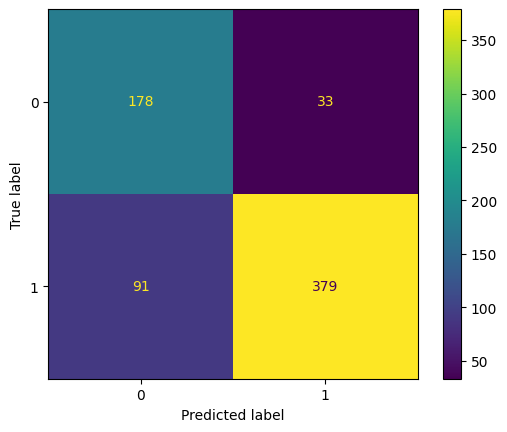

acc = 0.8179148311306902
balanced acc = 0.8249924372290007


In [7]:
y_hat = sm_model.predict(X_test)
show_conf_matrix(y_test, y_hat)
show_metrics(y_test, y_hat)

# Part 2: Soft-Margin SVM + RBF Kernel

In [8]:
class SoftMarginSVMKernel:
    def __init__(self, C=1, sigma=1):
        self.C = C
        self.weight = None
        self.bias = None
        self.sigma = sigma
        self.sv_x = None
        self.sv_y = None
        self.sv_alpha = None

    # vectorized version of RBF kernel
    def calc_rbf_kernel_matrix(self, X1, X2):
        # this function calculates the distance of each row of X1 with each row of X2
        # exactly what we need :)
        distance_matrix = scipy.spatial.distance_matrix(X1, X2)
        return np.exp(-(distance_matrix**2) / ((self.sigma**2) / 2))

    def train(self, X_train, y_train):
        n = X_train.shape[0]

        kernel_matrix = self.calc_rbf_kernel_matrix(X_train, X_train)
        P = cvxopt.matrix(np.outer(y_train, y_train) * kernel_matrix)
        q = cvxopt.matrix(-1 * np.ones(n))
        G = cvxopt.matrix(np.concatenate((-1 * np.identity(n), np.identity(n)), axis=0))
        h = cvxopt.matrix(
            np.concatenate((-1 * np.zeros(n), self.C * np.ones(n)), axis=0)
        )
        A = cvxopt.matrix(1.0 * y_train, (1, n))
        b = cvxopt.matrix(0.0)

        alpha = np.ravel(cvxopt.solvers.qp(P, q, G, h, A, b)["x"]).reshape(-1, 1)

        sv_mask = np.where((alpha > 1e-10) & (alpha <= self.C))[0]
        self.sv_x = X_train[sv_mask, :]
        self.sv_y = y_train[sv_mask]
        self.sv_alpha = alpha[sv_mask]

        margin_sv_mask = np.where((alpha > 1e-10) & (alpha < self.C))[0]
        first_margin_sv_x = X_train[margin_sv_mask, :][0].reshape(1, -1)
        first_margin_sv_y = y_train[margin_sv_mask][0]

        self.bias = first_margin_sv_y
        self.bias -= (
            np.dot(
                self.calc_rbf_kernel_matrix(self.sv_x, first_margin_sv_x).T,
                (self.sv_y * self.sv_alpha),
            )
        ).squeeze()

    def predict(self, X):
        return np.sign(
            np.dot(
                self.calc_rbf_kernel_matrix(X, self.sv_x), (self.sv_y * self.sv_alpha)
            ).squeeze()
        )

In [9]:
sm_kernel_model = SoftMarginSVMKernel()
sm_kernel_model.train(X_train, y_train)

     pcost       dcost       gap    pres   dres
 0: -1.8692e+02 -1.6974e+03  7e+03  2e+00  2e-15
 1: -1.5322e+02 -9.8053e+02  1e+03  1e-01  2e-15
 2: -1.6747e+02 -3.2750e+02  2e+02  2e-02  2e-15
 3: -1.8610e+02 -2.2635e+02  4e+01  3e-03  2e-15
 4: -1.9299e+02 -2.0342e+02  1e+01  4e-04  3e-15
 5: -1.9511e+02 -1.9775e+02  3e+00  4e-05  2e-15
 6: -1.9556e+02 -1.9670e+02  1e+00  1e-13  3e-15
 7: -1.9585e+02 -1.9603e+02  2e-01  1e-13  3e-15
 8: -1.9591e+02 -1.9591e+02  8e-03  3e-14  3e-15
 9: -1.9591e+02 -1.9591e+02  2e-04  1e-13  3e-15
Optimal solution found.


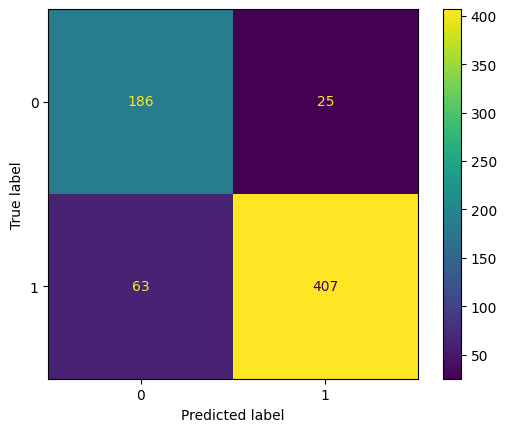

acc = 0.8707782672540382
balanced acc = 0.8737370172431178


In [10]:
y_hat = sm_kernel_model.predict(X_test)
show_conf_matrix(y_test, y_hat)
show_metrics(y_test, y_hat)